In [76]:
import numpy as np
import pandas as pd
from openbb_terminal.sdk import openbb
#from statsforecast.models import AutoARIMA
import requests
import re

import altair as a
from scipy.linalg import svd
#import lineapy

import joblib  #for saving models and preprocessing objects
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
%matplotlib inline

# Turn off warnings and messages 
import warnings
warnings.filterwarnings('ignore')


In [77]:
btc_df = openbb.crypto.load(symbol="btc",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
eth_df = openbb.crypto.load(symbol="eth",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
xrp_df= openbb.crypto.load(symbol='xrp', to_symbol='usd', start_date='2019-01-01', source="YahooFinance")
# Combine btc and eth dataframes and save under /data. Append current date to the filename. 
# Add a new column identifying which coin the row belongs to. 
btc_df['coin'] = 'btc'
eth_df['coin'] = 'eth'
xrp_df['coin']= 'xrp'
btc_eth_df = pd.concat([btc_df,eth_df],axis=0)

btc_eth_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,coin
date,,,,,,,
2023-10-19,1563.958130,1573.737671,1543.585083,1567.457031,1567.457031,5035110867,eth
2023-10-20,1567.570923,1628.609009,1562.302856,1604.666870,1604.666870,6747486127,eth
2023-10-21,1604.822266,1641.241821,1593.447998,1629.304443,1629.304443,4212179634,eth
2023-10-22,1629.297729,1667.666626,1623.984741,1663.429932,1663.429932,5248406817,eth
2023-10-23,1674.849243,1794.070435,1663.447998,1765.382690,1765.382690,14362295879,eth


In [78]:
btc= btc_eth_df[btc_eth_df.coin == 'btc']
btc.tail()

,Open,High,Low,Close,Adj Close,Volume,coin
date,,,,,,,
2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc
2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc
2023-10-21,29683.380859,30287.482422,29481.751953,29918.412109,29918.412109,11541146996,btc
2023-10-22,29918.654297,30199.433594,29720.312500,29993.896484,29993.896484,10446520040,btc
2023-10-23,30140.685547,34370.437500,30097.828125,33086.234375,33086.234375,38363572311,btc


In [4]:
btc.head()
btc = btc.reset_index()

In [5]:
btc['date'] = btc['date'].astype(str)  # Convert the column to a string
splitted= btc.date.str.split('-', expand=True)
btc['year']= splitted[0].astype('int')
btc['month']= splitted[1].astype('int')
btc['day']= splitted[2].astype('int')
btc.head()

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,btc,2019,1,1
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,btc,2019,1,2
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,btc,2019,1,3
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,btc,2019,1,4
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,btc,2019,1,5


In [6]:
btc['is_quarter_end']= np.where(btc['month']%3==0,1,0)
btc.tail()

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day,is_quarter_end
1750,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,17,0
1751,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,18,0
1752,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,19,0
1753,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,2023,10,20,0
1754,2023-10-21,29683.380859,30287.482422,29481.751953,29918.412109,29918.412109,11541146996,btc,2023,10,21,0


In [8]:
btc['open-close']= btc['Open']- btc['Close']
btc['low-high']= btc['Low']- btc['High']
btc['target']= np.where(btc['Close'].shift(-1) > btc.Close, 1, 0)
btc.tail()

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day,is_quarter_end,open-close,low-high,target
1750,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,17,0,106.349609,-508.566406,0
1751,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,18,0,85.189453,-714.757812,1
1752,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,19,0,-387.390625,-714.486328,1
1753,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,2023,10,20,0,-950.136719,-1502.416016,1
1754,2023-10-21,29683.380859,30287.482422,29481.751953,29918.412109,29918.412109,11541146996,btc,2023,10,21,0,-235.031250,-805.730469,0


In [9]:
#!pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics 
import warnings 
warnings.filterwarnings('ignore')
features= btc[['open-close', 'low-high', 'is_quarter_end']]
target= btc['target']

scaler= StandardScaler()
features= scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid= train_test_split(features, target, test_size=0.1, random_state=202)
print(X_train.shape, X_valid.shape)

(1579, 3) (176, 3)


In [10]:
models= [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, Y_train)
    
    print(f'{models[i]} :')
    print('Training Acc: ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Test Acc :', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()

LogisticRegression() :
Training Acc:  0.5320373849785615
Test Acc : 0.5251302083333333

SVC(kernel='poly', probability=True) :
Training Acc:  0.47518668401021347
Test Acc : 0.46809895833333337

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) :
Training Acc:  0.9634910311380899
Test Acc : 0

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(3):
    cm = confusion_matrix(Y_valid, models[i].predict(X_valid))
    plt.figure(figsize=(5,5))
    plt.title(f'{models[i]}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# metrics.ConfusionMatrixDisplay(models[0], X_valid, Y_valid)
# plt.show()

In [11]:
# Define the time period for RSI calculation (e.g., 14 days)
period = 14

# Calculate daily price changes
btc['Price Change'] = btc['Close'].diff()

# Separate gains (positive changes) and losses (negative changes)
btc['Gain'] = btc['Price Change'].apply(lambda x: x if x > 0 else 0)
btc['Loss'] = btc['Price Change'].apply(lambda x: abs(x) if x < 0 else 0)

# Calculate average gains and average losses over the specified period
btc['Avg Gain'] = btc['Gain'].rolling(window=period).mean()
btc['Avg Loss'] = btc['Loss'].rolling(window=period).mean()

# Calculate RS (Relative Strength)
btc['RS'] = btc['Avg Gain'] / btc['Avg Loss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

# Drop rows with missing values (due to the rolling averages)
btc = btc.dropna()

# Save the updated dataset with RSI values
btc.to_csv('updated_dataset_with_RSI.csv', index=False)


In [12]:
import pandas as pd
import numpy as np


# Sort the DataFrame by date (if it's not already sorted)
btc.sort_values(by='date', inplace=True)

# Calculate Simple Moving Average (SMA)
sma_period = 3  # Adjust as needed
btc['SMA'] = btc['Close'].rolling(window=sma_period).mean()

# Calculate Relative Strength Index (RSI)
rsi_period = 14  # Adjust as needed
delta = btc['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_period).mean()
avg_loss = loss.rolling(window=rsi_period).mean()
rs = avg_gain / avg_loss
btc['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
macd_fast_period = 12  # Adjust as needed
macd_slow_period = 26  # Adjust as needed
signal_period = 9  # Adjust as needed
ema_fast = btc['Close'].ewm(span=macd_fast_period).mean()
ema_slow = btc['Close'].ewm(span=macd_slow_period).mean()
btc['MACD'] = ema_fast - ema_slow
btc['Signal'] = btc['MACD'].ewm(span=signal_period).mean()

# Calculate Bollinger Bands
bb_period = 20  # Adjust as needed
btc['Middle_Band'] = btc['Close'].rolling(window=bb_period).mean()
btc['Upper_Band'] = btc['Middle_Band'] + (2 * btc['Close'].rolling(window=bb_period).std())
btc['Lower_Band'] = btc['Middle_Band'] - (2 * btc['Close'].rolling(window=bb_period).std())

# Calculate Stochastic Oscillator
k_period = 14  # Adjust as needed
d_period = 3  # Adjust as needed
low_min = btc['Low'].rolling(window=k_period).min()
high_max = btc['High'].rolling(window=k_period).max()
btc['%K'] = ((btc['Close'] - low_min) / (high_max - low_min)) * 100
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

# Calculate Average True Range (ATR)
atr_period = 14  # Adjust as needed
tr = np.maximum(np.maximum(btc['High'] - btc['Low'], abs(btc['High'] - btc['Close'].shift(1))),
                abs(btc['Low'] - btc['Close'].shift(1)))
btc['ATR'] = tr.rolling(window=atr_period).mean()

# Print or further analyze the DataFrame with manually calculated technical indicators
btc

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,RSI,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR
13,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
14,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,NaN,NaN,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN
15,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,NaN,3663.911458,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN
16,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,NaN,3654.748698,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN
17,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,NaN,3663.803385,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,...,61.238734,28031.622396,245.750636,184.325571,27466.764844,28547.975579,26385.554108,64.274896,54.399072,649.036133
1751,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,...,56.444949,28421.185547,290.695285,205.599514,27532.104590,28657.087796,26407.121384,61.250268,64.463056,658.765067
1752,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,...,65.856436,28487.965495,353.823527,235.244317,27622.508887,28825.473691,26419.544082,74.796616,66.773926,658.638393
1753,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,2023,10,...,69.105899,28910.365885,476.082686,283.411990,27758.260547,29232.402066,26284.119027,88.122827,74.723237,691.883510


In [13]:
btc_supply_data=openbb.crypto.onchain.btc_supply()
btc_supply_data

,x,y
0,2009-01-03 18:15:05,50.00
1,2009-01-15 02:55:41,26550.00
2,2009-01-19 20:08:35,53050.00
3,2009-01-24 14:28:00,79550.00
4,2009-01-28 14:02:26,106050.00
...,...,...
1495,2023-10-07 20:09:12,19506975.00
1496,2023-10-11 04:43:35,19510306.25
1497,2023-10-14 17:52:25,19513625.00
1498,2023-10-18 05:47:20,19516968.75


In [14]:

# Rename the 'x' column to 'date' and 'y' column to 'btc_supply'
btc_supply_data.rename(columns={'x': 'date', 'y': 'btc_supply'}, inplace=True)

# Convert the 'date' column to a datetime data type
btc_supply_data['date'] = pd.to_datetime(btc_supply_data['date'])

# Extract only the date part from the 'date' column
btc_supply_data['date'] = btc_supply_data['date'].dt.date

# Now your DataFrame should have 'date' as the date without time and 'btc_supply'
btc_supply_data.head()


,date,btc_supply
0,2009-01-03,50.0
1,2009-01-15,26550.0
2,2009-01-19,53050.0
3,2009-01-24,79550.0
4,2009-01-28,106050.0


In [15]:
# Convert 'date' columns to datetime objects with the same format
btc['date'] = pd.to_datetime(btc['date'])
btc_supply_data['date'] = pd.to_datetime(btc_supply_data['date'])

# Extract only the date part (remove time)
btc['date'] = btc['date'].dt.date
btc_supply_data['date'] = btc_supply_data['date'].dt.date

# Now, try the merge again
merged_data = btc.merge(btc_supply_data, on='date', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17480425.00
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,NaN,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,3663.911458,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,3654.748698,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,3663.803385,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN,17487075.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,...,28031.622396,245.750636,184.325571,27466.764844,28547.975579,26385.554108,64.274896,54.399072,649.036133,NaN
1738,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,...,28421.185547,290.695285,205.599514,27532.104590,28657.087796,26407.121384,61.250268,64.463056,658.765067,19516968.75
1739,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,...,28487.965495,353.823527,235.244317,27622.508887,28825.473691,26419.544082,74.796616,66.773926,658.638393,NaN
1740,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,2023,10,...,28910.365885,476.082686,283.411990,27758.260547,29232.402066,26284.119027,88.122827,74.723237,691.883510,NaN


In [16]:
x= openbb.crypto.onchain.btc_transac()
x.rename(columns={'x': 'date', 'y': 'confirmed_transactions'}, inplace=True)
x['date'] = pd.to_datetime(x['date'])
x['date'] = x['date'].dt.date

In [17]:
# Now, try the merge again
merged_data = merged_data.merge(x, on='date', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply,confirmed_transactions
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17480425.00,NaN
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296695.0
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN,17487075.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,...,245.750636,184.325571,27466.764844,28547.975579,26385.554108,64.274896,54.399072,649.036133,NaN,NaN
1738,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,...,290.695285,205.599514,27532.104590,28657.087796,26407.121384,61.250268,64.463056,658.765067,19516968.75,NaN
1739,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,...,353.823527,235.244317,27622.508887,28825.473691,26419.544082,74.796616,66.773926,658.638393,NaN,282007.0
1740,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,2023,10,...,476.082686,283.411990,27758.260547,29232.402066,26284.119027,88.122827,74.723237,691.883510,NaN,NaN


In [27]:
help(openbb.economy.treasury_chart)

Help on show_treasuries in module openbb_terminal.economy.fedreserve_view object:

class show_treasuries(builtins.object)
 |  show_treasuries(maturities: Union[Literal['1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y'], List[Literal['1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']]] = '1y', start_date: str = '1900-01-01', end_date: Optional[str] = '2023-10-22', raw: bool = False, external_axes: bool = False, export: str = '', sheet_name: Optional[str] = None) -> Optional[openbb_terminal.core.plots.plotly_helper.OpenBBFigure]
 |  
 |  Display U.S. Treasury rates [Source: EconDB]
 |  
 |  Parameters
 |  ----------
 |  maturities : list
 |      Treasury maturities to display.
 |  start_date : str
 |      Starting date, format "YEAR-MONTH-DAY", i.e. 2010-12-31.
 |  end_date : Optional[str]
 |      End date, format "YEAR-MONTH-DAY", i.e. 2020-06-05.
 |  raw : bool
 |      Whether to display the raw output.
 |  external_axes : bool, optional
 |      Whet

In [19]:
# trust= openbb.economy.trust(countries=['united_states'])
# trust.rename(columns={'united_states': 'trust_in_us_gov'}, inplace=True)
# trust.reset_index(inplace=True)
# Convert the 'time' column to a datetime object and extract the year
# trust['year'] = pd.to_datetime(trust['TIME']).dt.year
# trust.tail()

Error getting data from OECD: <urlopen error [SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED] unsafe legacy renegotiation disabled (_ssl.c:1129)>

In [ ]:
# # Now, try the merge again
# merged_data = merged_data.merge(trust, on='year', how='left', suffixes=('_left', '_right'))
# merged_data

In [28]:
merged_data.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'coin',
       'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high',
       'target', 'Price Change', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS',
       'RSI', 'SMA', 'MACD', 'Signal', 'Middle_Band', 'Upper_Band',
       'Lower_Band', '%K', '%D', 'ATR', 'btc_supply',
       'confirmed_transactions'],
      dtype='object')

In [30]:
treasury= openbb.economy.treasury()
treasury.tail()

,1m,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y
date,,,,,,,,,,,
2023-10-13,5.6,5.62,5.57,5.41,5.04,4.8,4.65,4.66,4.63,4.97,4.78
2023-10-16,5.57,5.61,5.58,5.42,5.09,4.87,4.72,4.74,4.71,5.06,4.87
2023-10-17,5.58,5.62,5.6,5.48,5.19,5.01,4.86,4.88,4.83,5.14,4.94
2023-10-18,5.57,5.61,5.58,5.47,5.19,5.03,4.92,4.95,4.91,5.2,5.0
2023-10-19,5.58,5.6,5.56,5.44,5.14,5.01,4.95,5.0,4.98,5.3,5.11


In [31]:
treasury= openbb.economy.treasury()
treasury.reset_index(inplace=True)
import pandas as pd

# Assuming 'date_column' is the name of the column you want to convert
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Now, 'date_column' is converted to a datetime dtype
merged_data = merged_data.merge(treasury, on='date', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,2.45,2.52,2.57,2.53,2.51,2.53,2.6,2.71,2.91,3.06
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,2.45,2.52,2.57,2.53,2.51,2.53,2.61,2.72,2.92,3.08
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,2.43,2.49,2.57,2.55,2.53,2.54,2.62,2.73,2.92,3.07
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,2.42,2.5,2.57,2.56,2.55,2.58,2.66,2.75,2.93,3.07
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,2.41,2.5,2.6,2.62,2.6,2.62,2.7,2.79,2.95,3.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,...,5.62,5.6,5.48,5.19,5.01,4.86,4.88,4.83,5.14,4.94
1738,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,...,5.61,5.58,5.47,5.19,5.03,4.92,4.95,4.91,5.2,5.0
1739,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,...,5.6,5.56,5.44,5.14,5.01,4.95,5.0,4.98,5.3,5.11
1740,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,2023,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Convert date to datetime
treasury['date'] = pd.to_datetime(treasury['date'])
treasury['date'] = treasury['date'].dt.date
treasury.head()

numeric_cols = ['1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']

# Convert all columns except date to numeric from the treasury dataframe
treasury[numeric_cols] = treasury[numeric_cols].apply(pd.to_numeric, errors='coerce')
treasury.dtypes

# Convert all columns except date to numeric from the treasury dataframe

# treasury = treasury.apply(pd.to_numeric, errors='coerce')
# treasury.head()

date     object
1m      float64
3m      float64
6m      float64
1y      float64
2y      float64
3y      float64
5y      float64
7y      float64
10y     float64
20y     float64
30y     float64
dtype: object

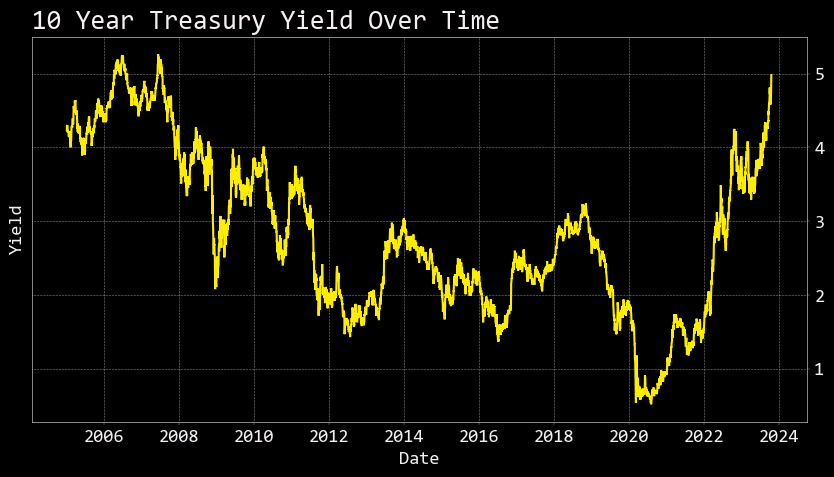

In [33]:
# Visualize treasury yields over time. Only use the treasury dataset  
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the treasury yields over time
plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='10y', data=treasury)
plt.title('10 Year Treasury Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.show()


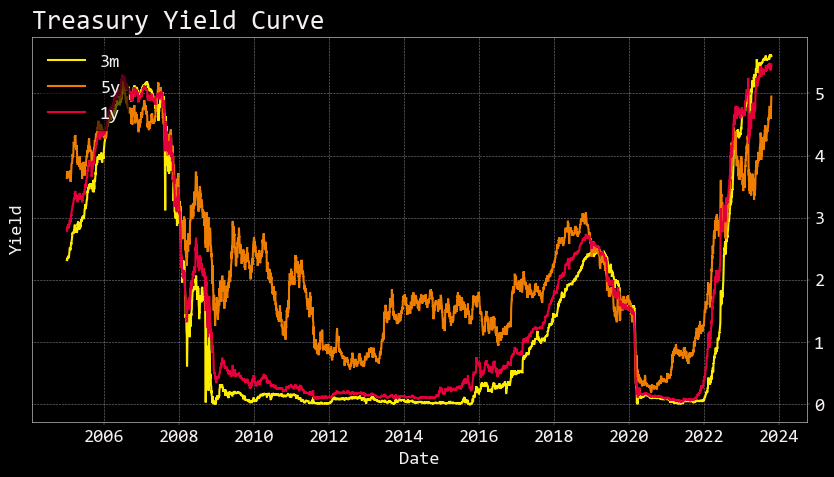

In [40]:
# Plot the 10 year yield versus the 3 and 6 month yields
plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='3m', data=treasury, label='3m')
sns.lineplot(x='date', y='5y', data=treasury, label='5y')
sns.lineplot(x='date', y='1y', data=treasury, label='1y')
plt.title('Treasury Yield Curve')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [ ]:
# spending= openbb.economy.spending(countries=['united_states'])
# spending.rename(columns={'united_states':'Spending United States'}, inplace=True)
# spending.reset_index(inplace=True)
# spending['year']= pd.to_datetime(spending['TIME']).dt.year
# merged_data = merged_data.merge(spending, on='year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [43]:
# spending= openbb.economy.spending(countries=['united_states'], start_date='2019-01-01')

In [44]:
# Convert the 'date' column to a datetime object and extract the quarter
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['quarter_year'] = 'Q' + merged_data['date'].dt.quarter.astype(str) + '_' + merged_data['date'].dt.year.astype(str)
merged_data.quarter_year.value_counts()

Q3_2021    92
Q4_2021    92
Q3_2019    92
Q4_2019    92
Q4_2022    92
Q3_2022    92
Q3_2020    92
Q4_2020    92
Q3_2023    92
Q2_2022    91
Q2_2021    91
Q2_2019    91
Q2_2020    91
Q1_2020    91
Q2_2023    91
Q1_2022    90
Q1_2021    90
Q1_2023    90
Q1_2019    77
Q4_2023    21
Name: quarter_year, dtype: int64

In [45]:
merged_data.shape

(1742, 45)

In [ ]:
# rgdp= openbb.economy.rgdp(countries=['united_states'])
# rgdp.reset_index(inplace=True)
# rgdp.rename(columns={'united_states': 'Gross domestic product (GDP) US'}, inplace=True)
# # Convert the 'date' column to a datetime object and extract the quarter
# rgdp['TIME'] = pd.to_datetime(rgdp['TIME'])
# rgdp['quarter_year'] = 'Q' + rgdp['TIME'].dt.quarter.astype(str) + '_' + rgdp['TIME'].dt.year.astype(str)

# rgdp.tail(2)

In [ ]:
# merged_data = merged_data.merge(rgdp, on='quarter_year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [ ]:
# revenue= openbb.economy.revenue(countries=['united_states'])
# revenue.reset_index(inplace=True)
# revenue.rename(columns={'united_states': 'Revenue US'}, inplace=True)
# # Convert the 'date' column to a datetime object and extract the quarter
# revenue['TIME'] = pd.to_datetime(revenue['TIME'])
# revenue['year']= pd.to_datetime(revenue['TIME']).dt.year
# revenue.tail()

In [ ]:
# merged_data = merged_data.merge(revenue, on='year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [50]:
index= openbb.economy.index(indices=['sp500', 'nyse', 'crypto200', 'cboe_vix3m'])
index.tail()

,sp500,nyse,crypto200,cboe_vix3m
Date,,,,
2023-10-16,4373.629883,15484.500000,596.070984,18.790001
2023-10-17,4373.200195,15541.379883,592.570984,19.260000
2023-10-18,4314.600098,15324.959961,589.887024,20.469999
2023-10-19,4278.000000,15196.370117,594.487976,22.190001
2023-10-20,4224.160156,15033.309570,613.969971,22.440001


In [51]:
index= openbb.economy.index(indices=['sp500', 'nyse', 'crypto200', 'cboe_vix3m'])
index.reset_index(inplace=True)
index.rename(columns={'crypto200': 'CMC Crypto 200 Index by Solacti', 'cboe_vix3m': 'CBOE S&P 500 3-Month Volatility Index', 'Date': 'date'}, inplace=True)
index

,date,sp500,nyse,CMC Crypto 200 Index by Solacti,CBOE S&P 500 3-Month Volatility Index
0,1927-12-30,17.660000,NaN,NaN,NaN
1,1928-01-03,17.760000,NaN,NaN,NaN
2,1928-01-04,17.719999,NaN,NaN,NaN
3,1928-01-05,17.549999,NaN,NaN,NaN
4,1928-01-06,17.660000,NaN,NaN,NaN
...,...,...,...,...,...
24062,2023-10-16,4373.629883,15484.500000,596.070984,18.790001
24063,2023-10-17,4373.200195,15541.379883,592.570984,19.260000
24064,2023-10-18,4314.600098,15324.959961,589.887024,20.469999
24065,2023-10-19,4278.000000,15196.370117,594.487976,22.190001


In [52]:
merged_data = merged_data.merge(index, on='date',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1742, 49)

In [ ]:
# balance=openbb.economy.balance(countries= ['united_states'])
# balance.reset_index(inplace=True)
# balance.rename(columns={'united_states': 'Balance US'}, inplace=True)
# balance['TIME'] = pd.to_datetime(balance['TIME'])
# balance['year']= pd.to_datetime(balance['TIME']).dt.year
# balance.tail(2)

In [ ]:
# merged_data = merged_data.merge(balance, on='year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [ ]:
# #Inflation measured by consumer price index (CPI)
# ccpi= openbb.economy.ccpi(countries=['united_states'])
# ccpi.reset_index(inplace=True)
# ccpi.rename(columns={'united_states': 'consumer price index(ccpi inflation measure) US'}, inplace=True)
# # Convert the 'date' column to a datetime object and extract the quarter
# ccpi['TIME'] = pd.to_datetime(ccpi['TIME'])
# ccpi['quarter_year'] = 'Q' + ccpi['TIME'].dt.quarter.astype(str) + '_' + ccpi['TIME'].dt.year.astype(str)
# ccpi.tail()

# Many calls to the openbb.economy model return the following error. 
Error getting data from OECD: <urlopen error [SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED] unsafe legacy renegotiation disabled (_ssl.c:1129)>

In [55]:
ccpi= openbb.economy.ccpi(countries=['united_states'])

Error getting data from OECD: <urlopen error [SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED] unsafe legacy renegotiation disabled (_ssl.c:1129)>

In [ ]:
# merged_data = merged_data.merge(ccpi, on='quarter_year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [ ]:
# debt= openbb.economy.debt(countries=['united_states'])
# debt.reset_index(inplace=True)
# debt.rename(columns={'united_states': 'debt-to-GDP ratio US'}, inplace=True)
# debt['TIME'] = pd.to_datetime(debt['TIME'])
# debt['year']= pd.to_datetime(debt['TIME']).dt.year
# debt.tail(5)

In [ ]:
# merged_data = merged_data.merge(debt, on='year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [ ]:
#Real gross domestic product (GDP)
# fgdp= openbb.economy.fgdp(countries=['united_states'])
# fgdp.reset_index(inplace=True)
# fgdp.rename(columns={'united_states': 'Real gross domestic product (GDP) US'}, inplace=True)
# # Convert the 'date' column to a datetime object and extract the quarter
# fgdp['TIME'] = pd.to_datetime(fgdp['TIME'])
# fgdp['quarter_year'] = 'Q' + fgdp['TIME'].dt.quarter.astype(str) + '_' + fgdp['TIME'].dt.year.astype(str)
# fgdp.tail(5)

In [ ]:
# merged_data = merged_data.merge(fgdp, on='quarter_year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [ ]:
# gdp= openbb.economy.gdp(countries=['united_states'])
# gdp.reset_index(inplace=True)
# gdp.rename(columns={'united_states': 'GDP per Capita US'}, inplace=True)
# # Convert the 'date' column to a datetime object and extract the quarter
# gdp['TIME'] = pd.to_datetime(gdp['TIME'])
# gdp['year'] = gdp['TIME'].dt.year
# gdp.tail(5)

In [ ]:
# merged_data = merged_data.merge(gdp, on='year',how='left', suffixes=('_left', '_right'))
# merged_data.shape

In [58]:
bb= openbb.economy

In [59]:
data_tuple= bb.macro()
# Extract the DataFrame from the tuple
cpi_df = data_tuple[0]

# Reset the index to make 'date' a column
cpi_df.reset_index(inplace=True)

# Rename the columns
cpi_df.columns = ['date', 'CPI']

# Convert 'date' column to datetime type
cpi_df['date'] = pd.to_datetime(cpi_df['date'])

# Print the DataFrame
cpi_df



,date,CPI
0,1947-01-01,21.480000
1,1947-02-01,21.620001
2,1947-03-01,22.000000
3,1947-04-01,22.000000
4,1947-05-01,21.950001
...,...,...
916,2023-05-01,303.299988
917,2023-06-01,303.799988
918,2023-07-01,304.299988
919,2023-08-01,306.299988


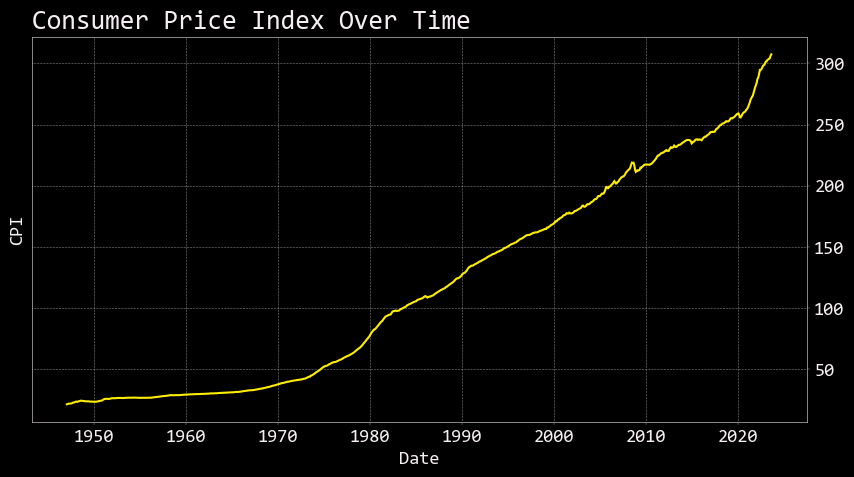

In [60]:
# Plot CPI over time 
plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='CPI', data=cpi_df)
plt.title('Consumer Price Index Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

In [61]:
cpi_df['year_month'] = cpi_df['date'].dt.strftime('%Y-%m')
cpi_df.rename(columns={'CPI': 'US CPI'}, inplace=True)
cpi_df.tail()

,date,US CPI,year_month
916,2023-05-01,303.299988,2023-05
917,2023-06-01,303.799988,2023-06
918,2023-07-01,304.299988,2023-07
919,2023-08-01,306.299988,2023-08
920,2023-09-01,307.500000,2023-09


In [62]:
cpi_df['year_month'] = cpi_df['date'].dt.strftime('%Y-%m')
cpi_df.rename(columns={'CPI': 'US CPI'}, inplace=True)
merged_data['year_month']= merged_data['date'].dt.strftime('%Y-%m')

In [63]:
merged_data = merged_data.merge(cpi_df, on='year_month',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1742, 52)

In [64]:
merged_data.rename(columns={'date_left': 'Date'}, inplace=True)

In [66]:
merged_data.columns
#merged_data.drop(columns={'TIME_right', 'TIME_left', 'date_right'}, inplace=True)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'coin',
       'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high',
       'target', 'Price Change', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS',
       'RSI', 'SMA', 'MACD', 'Signal', 'Middle_Band', 'Upper_Band',
       'Lower_Band', '%K', '%D', 'ATR', 'btc_supply', 'confirmed_transactions',
       '1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y',
       'quarter_year', 'sp500', 'nyse', 'CMC Crypto 200 Index by Solacti',
       'CBOE S&P 500 3-Month Volatility Index', 'year_month', 'date_right',
       'US CPI'],
      dtype='object')

In [67]:
pd.set_option('display.max_columns', None)

merged_data

,Date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day,is_quarter_end,open-close,low-high,target,Price Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply,confirmed_transactions,1m,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y,quarter_year,sp500,nyse,CMC Crypto 200 Index by Solacti,CBOE S&P 500 3-Month Volatility Index,year_month,date_right,US CPI
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,14,0,-148.741211,-175.551025,0,153.099121,153.099121,0.000000,37.420846,47.239973,0.792144,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17480425.00,NaN,2.42,2.45,2.52,2.57,2.53,2.51,2.53,2.6,2.71,2.91,3.06,Q1_2019,2582.610107,11799.110352,98.120003,19.930000,2019-01,2019-01-01,252.699997
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,15,0,73.541016,-100.204102,1,-75.376953,0.000000,75.376953,37.420846,52.624041,0.711098,NaN,NaN,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.41,2.45,2.52,2.57,2.53,2.51,2.53,2.61,2.72,2.92,3.08,Q1_2019,2610.300049,11868.679688,95.599998,19.240000,2019-01,2019-01-01,252.699997
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,16,0,-23.497070,-61.103760,1,24.331543,24.331543,0.000000,32.023856,52.624041,0.608540,NaN,3663.911458,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.41,2.43,2.49,2.57,2.55,2.53,2.54,2.62,2.73,2.92,3.07,Q1_2019,2616.100098,11907.610352,96.639999,19.530001,2019-01,2019-01-01,252.699997
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,17,0,-26.692871,-58.175049,0,23.557129,23.557129,0.000000,33.706508,45.004883,0.748952,NaN,3654.748698,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296695.0,2.41,2.42,2.5,2.57,2.56,2.55,2.58,2.66,2.75,2.93,3.07,Q1_2019,2635.959961,11994.540039,97.279999,19.170000,2019-01,2019-01-01,252.699997
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,18,0,20.151123,-45.439209,1,-20.724609,0.000000,20.724609,32.208200,46.485212,0.692870,NaN,3663.803385,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN,17487075.00,NaN,2.4,2.41,2.5,2.6,2.62,2.6,2.62,2.7,2.79,2.95,3.09,Q1_2019,2670.709961,12151.769531,96.230003,18.840000,2019-01,2019-01-01,252.699997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,2023-10-17,28522.097656,28618.751953,28110.185547,28415.748047,28415.748047,14872527508,btc,2023,10,17,0,106.349609,-508.566406,0,-103.718750,0.000000,103.718750,191.834263,121.422154,1.579895,61.238734,28031.622396,245.750636,184.325571,27466.764844,28547.975579,26385.554108,64.274896,54.399072,649.036133,NaN,NaN,5.58,5.62,5.6,5.48,5.19,5.01,4.86,4.88,4.83,5.14,4.94,Q4_2023,4373.200195,15541.379883,592.570984,19.260000,2023-10,NaT,NaN
1738,2023-10-18,28413.531250,28889.009766,28174.251953,28328.341797,28328.341797,12724128586,btc,2023,10,18,0,85.189453,-714.757812,1,-87.406250,0.000000,87.406250,165.447405,127.665458,1.295945,56.444949,28421.185547,290.695285,205.599514,27532.104590,28657.087796,26407.121384,61.250268,64.463056,658.765067,19516968.75,NaN,5.57,5.61,5.58,5.47,5.19,5.03,4.92,4.95,4.91,5.2,5.0,Q4_2023,4314.600098,15324.959961,589.887024,20.469999,2023-10,NaT,NaN
1739,2023-10-19,28332.416016,28892.474609,28177.988281,28719.806641,28719.806641,14448058195,btc,2023,10,19,0,-387.390625,-714.486328,1,391.464844,391.464844,0.000000,193.409180,100.273856,1.928810,65.856436,28487.965495,353.823527,235.244317,27622.508887,28825.473691,26419.544082,74.796616,66.773926,658.638393,NaN,282007.0,5.58,5.6,5.56,5.44,5.14,5.01,4.95,5.0,4.98,5.3,5.11,Q4_2023,4278.000000,15196.370117,594.487976,22.190001,2023-10,NaT,NaN
1740,2023-10-20,28732.812500,30104.085938,28601.669922,29682.949219,29682.949219,21536125230,btc,20

In [68]:
merged_data.isna().sum()

Date                                        0
Open                                        0
High                                        0
Low                                         0
Close                                       0
Adj Close                                   0
Volume                                      0
coin                                        0
year                                        0
month                                       0
day                                         0
is_quarter_end                              0
open-close                                  0
low-high                                    0
target                                      0
Price Change                                0
Gain                                        0
Loss                                        0
Avg Gain                                    0
Avg Loss                                    0
RS                                          0
RSI                               

In [73]:
cry_dd= openbb.crypto.dd
cry_dd

CryptoDueDiligence(

Attributes:
    active: Returns active addresses of a certain symbol
    active_chart: Plots active addresses of a certain symbol over time
    all_binance_trading_pairs: Returns all available pairs on Binance in DataFrame format. DataFrame has 3 columns symbol, baseAsset, quoteAsset
    ath: Get all time high for a coin in a given currency
    atl: Get all time low for a coin in a given currency
    balance: Get account holdings for asset. [Source: Binance]
    balance_chart: Prints table showing account holdings for asset. [Source: Binance]
    basic: Basic coin information [Source: CoinPaprika]
    basic_chart: Prints table showing basic information for coin. Like:
    binance_available_quotes_for_each_coin: Helper methods that for every coin available on Binance add all quote assets. [Source: Binance]
    candle: Get candles for chosen trading pair and time interval. [Source: Coinbase]
    change: Returns 30d change of the supply held in exchange wallets of a c

In [75]:
# Count the number of observations by coin 
merged_data.groupby('coin').count()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day,is_quarter_end,open-close,low-high,target,Price Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply,confirmed_transactions,1m,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y,quarter_year,sp500,nyse,CMC Crypto 200 Index by Solacti,CBOE S&P 500 3-Month Volatility Index,year_month,date_right,US CPI
coin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
btc,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742,1729,1740,1742,1742,1723,1723,1723,1729,1727,1728,480,435,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1742,1202,1202,1165,1202,1742,1721,1721
